<a href="https://colab.research.google.com/github/ksk94966/XNN_Math/blob/master/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
import os.path
import urllib.request
import gzip
import math
import numpy  as np
import matplotlib.pyplot as plt

# data
DATA_NUM_TRAIN         = 60000
DATA_NUM_TEST          = 10000
DATA_CHANNELS          = 1
DATA_ROWS              = 28
DATA_COLS              = 28
DATA_CLASSES           = 10
DATA_URL_TRAIN_DATA    = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
DATA_URL_TRAIN_LABELS  = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'
DATA_URL_TEST_DATA     = 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz'
DATA_URL_TEST_LABELS   = 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'
DATA_FILE_TRAIN_DATA   = 'train_data.gz'
DATA_FILE_TRAIN_LABELS = 'train_labels.gz'
DATA_FILE_TEST_DATA    = 'test_data.gz'
DATA_FILE_TEST_LABELS  = 'test_labels.gz'

# display
DISPLAY_ROWS   = 8
DISPLAY_COLS   = 4
DISPLAY_COL_IN = 10
DISPLAY_ROW_IN = 25
DISPLAY_NUM    = DISPLAY_ROWS*DISPLAY_COLS

# download
if (os.path.exists(DATA_FILE_TRAIN_DATA)   == False):
    urllib.request.urlretrieve(DATA_URL_TRAIN_DATA,   DATA_FILE_TRAIN_DATA)
if (os.path.exists(DATA_FILE_TRAIN_LABELS) == False):
    urllib.request.urlretrieve(DATA_URL_TRAIN_LABELS, DATA_FILE_TRAIN_LABELS)
if (os.path.exists(DATA_FILE_TEST_DATA)    == False):
    urllib.request.urlretrieve(DATA_URL_TEST_DATA,    DATA_FILE_TEST_DATA)
if (os.path.exists(DATA_FILE_TEST_LABELS)  == False):
    urllib.request.urlretrieve(DATA_URL_TEST_LABELS,  DATA_FILE_TEST_LABELS)

# training data
# unzip the file, skip the header, read the rest into a buffer and format to NCHW
file_train_data   = gzip.open(DATA_FILE_TRAIN_DATA, 'r')
file_train_data.read(16)
buffer_train_data = file_train_data.read(DATA_NUM_TRAIN*DATA_ROWS*DATA_COLS)
train_data        = np.frombuffer(buffer_train_data, dtype=np.uint8).astype(np.float32)
train_data        = train_data.reshape(DATA_NUM_TRAIN, 1, DATA_ROWS, DATA_COLS)

# training labels
# unzip the file, skip the header, read the rest into a buffer and format to a vector
file_train_labels   = gzip.open(DATA_FILE_TRAIN_LABELS, 'r')
file_train_labels.read(8)
buffer_train_labels = file_train_labels.read(DATA_NUM_TRAIN)
train_labels        = np.frombuffer(buffer_train_labels, dtype=np.uint8).astype(np.int32)

# testing data
# unzip the file, skip the header, read the rest into a buffer and format to NCHW
file_test_data   = gzip.open(DATA_FILE_TEST_DATA, 'r')
file_test_data.read(16)
buffer_test_data = file_test_data.read(DATA_NUM_TEST*DATA_ROWS*DATA_COLS)
test_data        = np.frombuffer(buffer_test_data, dtype=np.uint8).astype(np.float32)
test_data        = test_data.reshape(DATA_NUM_TEST, 1, DATA_ROWS, DATA_COLS)

# testing labels
# unzip the file, skip the header, read the rest into a buffer and format to a vector
file_test_labels   = gzip.open(DATA_FILE_TEST_LABELS, 'r')
file_test_labels.read(8)
buffer_test_labels = file_test_labels.read(DATA_NUM_TEST)
test_labels        = np.frombuffer(buffer_test_labels, dtype=np.uint8).astype(np.int32)

In [120]:
#Printing dimensions
print(train_data.shape)   # (60000, 1, 28, 28)
print(train_labels.shape) # (60000,)
print(test_data.shape)    # (10000, 1, 28, 28)
print(test_labels.shape)  # (10000,)

(60000, 1, 28, 28)
(60000,)
(10000, 1, 28, 28)
(10000,)


In [121]:
#hidden Layer1
wh1 = np.random.rand(784,1000)/np.sqrt(784)
bh1 = np.random.rand(1,1000)

#hidden Layer2
wh2 = np.random.rand(1000,100)/np.sqrt(1000)
bh2 = np.random.rand(1,100)

#Output Layer
wo = np.random.rand(100,10)/np.sqrt(100)
bo = np.random.rand(1,10)

In [122]:
def multi1(v):
  return np.dot(v,wh1)

def multi2(v):
  return np.dot(v,wh2)

def multi3(v):
  return np.dot(v,wo)

def ReLU(x):
  return np.maximum(0,x)

def reluDerivative(x):
  x[x<=0] = 0
  x[x>0] = 1
  return x

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x /np.sum(e_x)

def getLabelMatrix(i):
  lab = np.zeros((1,10))
  lab[0][i] = 1
  return lab

{0: 0.6714285714285714, 1: 0.9594017094017094, 2: 0.4223744292237443, 3: 0.533816425120773, 4: 0.652073732718894, 5: 0.9608938547486033, 6: 0.7556179775280899, 7: 0.6024390243902439, 8: 0.5833333333333334, 9: 0.8273195876288659}


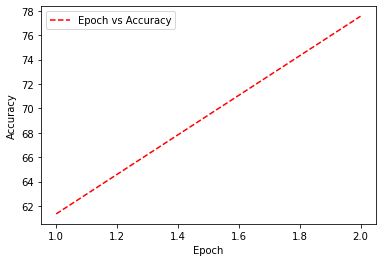

In [123]:
import timeit

epoch_accuracy = dict()
accuracy_label_encountered = dict()
accuracy_label_correct = dict()

for i in range(10):
  accuracy_label_encountered[i] = 0       

for i in range(10):
  accuracy_label_correct[i] = 0

lr = 0.001                    # Learning Rate

train_data =  (train_data/255).astype('float32')
test_data =  (test_data/255).astype('float32')


#testing forward pass function

def testingNN(testdata,testlabels):
  count = 0;
  total = 0; 
#Forward Pass
  for sample in range(2000):
    a0 = testdata[sample]                                                                    #division by 255
    a0 = a0.reshape(1,784)                                                                 #Reshaping ---> Vectorization
    #print(bh1)

    #Passing the sample through first hidden layer
    zh1 = np.add(multi1(a0) ,bh1)                                                                    #Creating Zh1 which is addtion of weights and bias
    ah1 = ReLU(zh1)                                                                                            #Generated hiddenlayer1 Activations
    # print(ah1)

    #passing the h1 sample through second hiddden layer
    zh2 = np.add(multi2(ah1), bh2)                                                                   #Creating Zh2 which is addtion of weights and bias
    ah2 = ReLU(zh2)                                                                                             #Generated hiddenlayer2 Activations 
    

    #passing the h2 sample through third hiddden layer
    zo = np.add(multi3(ah2) ,bo)                                                                        #Creating Zo which is addtion of weights and bias
    ao = softmax(zo)                                                                                             #Generated output Activations
    #print(ao)

    pred = np.argmax(ao)

    #print(pred)

    y = getLabelMatrix(testlabels[sample])                          #desired output label

    accuracy_label_encountered[testlabels[sample]] += 1
    #print(y)

    if(y[0][pred]):
      count += 1
      accuracy_label_correct[pred] += 1 
    
    total += 1

  #print((count/total)*100)

  return (count/total)*100

count = 0;
total = 0; 
#Training epochs 
for epoch in range(2):
  epoch_number = epoch + 1
  start = timeit.timeit()
  total_LossPerEpoch = 0
  #Training Forward Pass
  for sample in range(40000):
    a0 = np.copy(train_data[sample])                                               
    a0 = a0.reshape(1,784)                                                                 #Reshaping ---> Vectorization
    # print(bh1)

    #Passing the sample through first hidden layer
    zh1 = np.add(multi1(a0) ,bh1)                                                                    #Creating Zh1 which is addtion of weights and bias
    ah1 = ReLU(zh1)                                                                                            #Generated hiddenlayer1 Activations
    # print(ah1)

    #passing the h1 sample through second hiddden layer
    zh2 = np.add(multi2(ah1), bh2)                                                                   #Creating Zh2 which is addtion of weights and bias
    ah2 = ReLU(zh2)                                                                                             #Generated hiddenlayer2 Activations 
    
    #passing the sample to get output
    zo = np.add(multi3(ah2) ,bo)                                                                        #Creating Zo which is addtion of weights and bias
    ao = softmax(zo)                                                                                             #Generated output Activations
    #print(ao)

    y = getLabelMatrix(train_labels[sample])                                              #desired output label

    #Here we are using entropy function as loss function
    #BackPropagation----------------------------------------------------------

    #phase 1              ---> for the output layer
    dcost_dzo = ao - y                                                                             #(1,10)
    dzo_dwo = ah2.transpose()                                                            #(1,100)   --> we have to transpose this one
    dcost_dwo = np.dot( dzo_dwo,dcost_dzo)                                 #derivate of cost w.r.t output weights      #(100,10)
    dcost_dbo = dcost_dzo                                                                   #derivative of cost w.r.t bias                      #(1,10)

    #phase 2              ---> for the hidden layer 2 
    dzo_dah2 = wo
    dcost_dah2 = np.dot(dcost_dzo , dzo_dah2.transpose())
    dah2_dzh2 = reluDerivative(zh2)
    dzh2_dwh2 = ah1
    dcost_dwh2 = np.dot(dzh2_dwh2.T,dah2_dzh2*dcost_dah2)
    dcost_dbh2 = dcost_dah2 * dah2_dzh2
    #print(dcost_dwh2)

    #phase 3   ---- > for hidden layer 1
    dzh2_dah1 = wh2
    dcost_dzh2 = dcost_dah2 * dah2_dzh2
    dcost_dah1 = np.dot(dcost_dzh2,dzh2_dah1.transpose()) 
    dah1_dzh1 = reluDerivative(zh1)
    dzh1_dwh1 = a0
    dcost_dwh1 = np.dot(dzh1_dwh1.T,dah1_dzh1 *dcost_dah1)
    dcost_dbh1 = dcost_dah1 * dah1_dzh1
    #print(dzh1_dwh1)

    wh1 -= lr * dcost_dwh1
    bh1 -= lr * dcost_dbh1.sum(axis=0)

    wh2 -= lr * dcost_dwh2
    bh2 -= lr * dcost_dbh2.sum(axis=0)

    wo -= lr * dcost_dwo
    bo -= lr * dcost_dbo.sum(axis=0)
    
    loss = np.sum(-y * np.log(ao))
    total_LossPerEpoch += loss
    #print('Loss function value: ', loss)
  end = timeit.timeit()
  time_elapsed = end - start
  total_LossPerEpoch = total_LossPerEpoch/10000
  test_accuracy_epoch =  testingNN(test_data,test_labels)
  epoch_accuracy[epoch_number] = test_accuracy_epoch                  #plot for epoch vs accuracy


accuracy_display = dict()
for i in range(10):
    if(accuracy_label_encountered[i]!=0):
      accuracy_display[i]  = accuracy_label_correct[i]/accuracy_label_encountered[i]
    else:
      accuracy_display[i] = 0  

print(accuracy_display)
#final Value

#plotting

epoch_count = []
epoch_testAccuracy = []
for key in epoch_accuracy:
  epoch_count.append(key)
  epoch_testAccuracy.append(epoch_accuracy[key])

plt.plot(epoch_count, epoch_testAccuracy, 'r--')
plt.legend(['Epoch vs Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()      
    

In [83]:
def testingNN(testdata,testlabels):
  count = 0;
  total = 0; 
#Forward Pass
  for sample in range(5000):
    a0 = testdata[sample]                                                                    #division by 255
    a0 = a0.reshape(1,784)                                                                 #Reshaping ---> Vectorization
    #print(bh1)

    #Passing the sample through first hidden layer
    zh1 = np.add(multi1(a0) ,bh1)                                                                    #Creating Zh1 which is addtion of weights and bias
    ah1 = ReLU(zh1)                                                                                            #Generated hiddenlayer1 Activations
    # print(ah1)

    #passing the h1 sample through second hiddden layer
    zh2 = np.add(multi2(ah1), bh2)                                                                   #Creating Zh2 which is addtion of weights and bias
    ah2 = ReLU(zh2)                                                                                             #Generated hiddenlayer2 Activations 
    

    #passing the h2 sample through third hiddden layer
    zo = np.add(multi3(ah2) ,bo)                                                                        #Creating Zo which is addtion of weights and bias
    ao = softmax(zo)                                                                                             #Generated output Activations
    #print(ao)

    pred = np.argmax(ao)

    #print(pred)

    y = getLabelMatrix(testlabels[sample])                          #desired output label

    #print(y)

    if(y[0][pred]):
      count += 1
    
    total += 1

  print((count/total)*100)

  return (count/total)*100

In [85]:
print(testingNN(test_data,test_labels))

88.32
88.32
